# Week 7: Line Plot of IoT Sensor Readings Over Time

The primary objective of this homework assignment is to illustrate the temporal readings of IoT sensor data acquired following the data retrieval and processing phases within the blockchain ledger from the previous assignment. Additionally, I will incorporate other analyses and visualizations that are necessary for the timely completion of my MS 2.

This analysis pipeline demonstrates effective monitoring of water quality through IoT sensor data by combining time-series visualization, statistical anomaly detection with z-scores, and sensor diagnostic checks for calibration or stuck sensors. Temperature sensors show natural variability essential for contextual analysis. Further, correlation analyses and sudden change detection provide enhanced insights for operational decision-making.

The findings highlight the importance of regular sensor calibration, attention to zero/stuck sensor behavior, and employing statistical thresholds to manage sensor data quality. Integrating these methods supports robust, real-time water quality monitoring with actionable alerts for maintaining environmental safety and compliance.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

In [2]:
# Load the dataset (assuming saved as 'cleaned_iot_data.csv' or adapted for direct input)
df = pd.read_csv('cleaned_iot_data.csv', parse_dates=['timestamp'])

# Set timestamp as index for time series handling
df.set_index('timestamp', inplace=True)

sns.set(style="whitegrid")

In [3]:
df.tail()

,sensor_id,data_type,value,numeric_value
timestamp,,,,
2025-06-11 15:06:15,SENSOR_Conductivity_µS_cm,Conductivity (µS/cm),204,204
2025-06-11 15:06:15,SENSOR_pH,pH,8,8
2025-06-11 15:06:15,SENSOR_Temperature_°C,Temperature (°C),6,6
2025-06-11 15:06:15,SENSOR_Turbidity_NTU,Turbidity (NTU),0,0
2025-06-11 15:06:15,SENSOR_Conductivity_µS_cm,Conductivity (µS/cm),203,203


In [4]:
# Get the actual column names
print(df.columns.tolist())

['sensor_id', 'data_type', 'value', 'numeric_value']


## Calculate Descriptive Statistics for Each Sensor

In [6]:
descriptive_stats = df.groupby('sensor_id')['numeric_value'].describe()

# Display the descriptive statistics
print(descriptive_stats)

# Optionally, save the stats to a CSV file
descriptive_stats.to_csv('sensor_descriptive_statistics.csv')

                           count    mean       std    min    25%    50%  \
sensor_id                                                                 
SENSOR_ClO2_mg_L            52.0    0.00  0.000000    0.0    0.0    0.0   
SENSOR_Conductivity_µS_cm  100.0  209.85  4.854187  199.0  205.0  210.0   
SENSOR_Temperature_°C      100.0    7.74  1.219538    3.0    7.0    8.0   
SENSOR_Turbidity_NTU       100.0    0.00  0.000000    0.0    0.0    0.0   
SENSOR_pH                  100.0    8.00  0.000000    8.0    8.0    8.0   

                              75%    max  
sensor_id                                 
SENSOR_ClO2_mg_L             0.00    0.0  
SENSOR_Conductivity_µS_cm  214.00  222.0  
SENSOR_Temperature_°C        8.25   10.0  
SENSOR_Turbidity_NTU         0.00    0.0  
SENSOR_pH                    8.00    8.0  


## Basic Line Plot Over Time

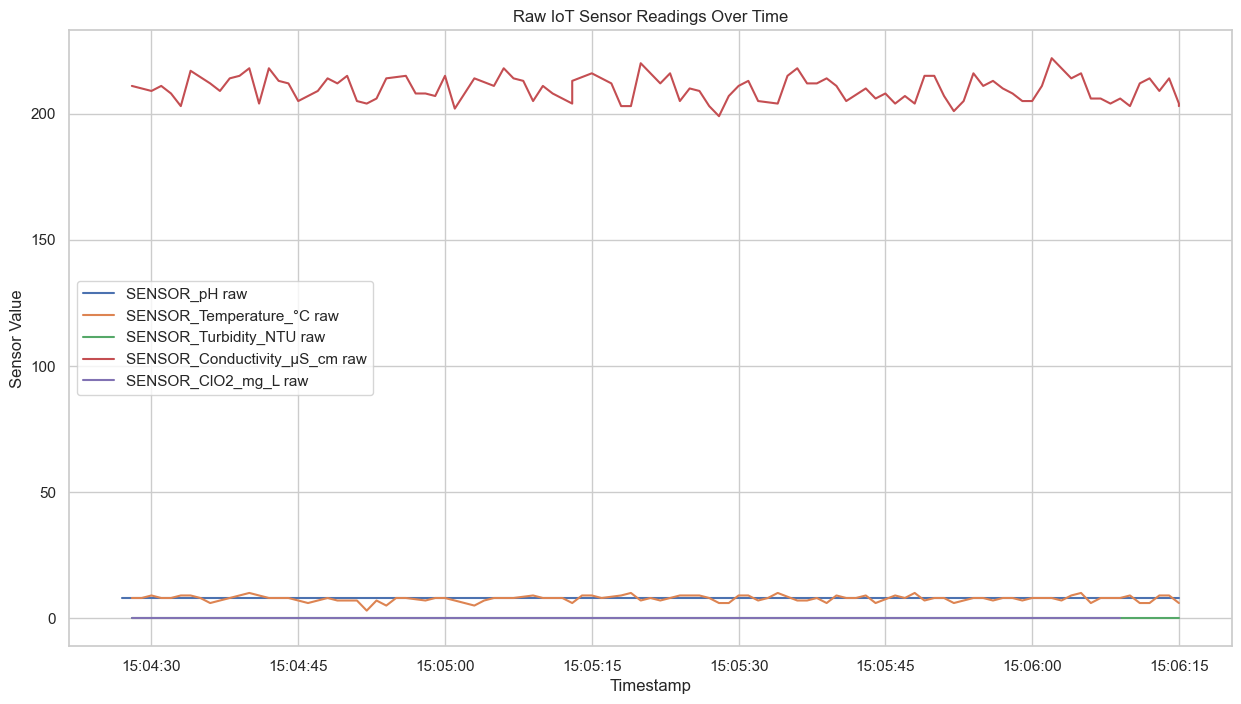

In [7]:
# Plot raw sensor readings over time for each sensor_id
plt.figure(figsize=(15, 8))
for sensor in df['sensor_id'].unique():
    sensor_data = df[df['sensor_id'] == sensor].sort_index()
    plt.plot(sensor_data.index, sensor_data['numeric_value'], label=f'{sensor} raw')
plt.title('Raw IoT Sensor Readings Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Sensor Value')
plt.legend(loc='center left')
plt.show()

## Smoothed Data Line Plot Over Time

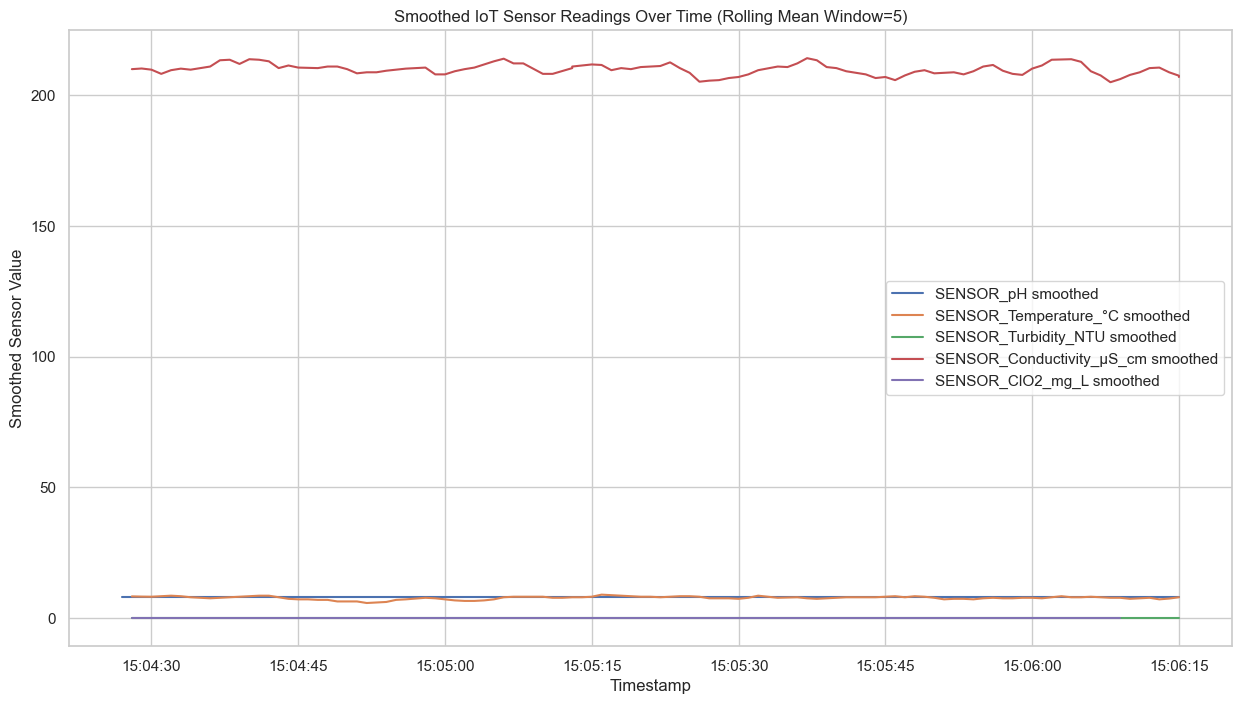

In [8]:
# Plot smoothed data using rolling mean (window: 5)
plt.figure(figsize=(15, 8))
for sensor in df['sensor_id'].unique():
    sensor_data = df[df['sensor_id'] == sensor].sort_index()
    smoothed = sensor_data['numeric_value'].rolling(window=5, min_periods=1, center=True).mean()
    plt.plot(sensor_data.index, smoothed, label=f'{sensor} smoothed')
plt.title('Smoothed IoT Sensor Readings Over Time (Rolling Mean Window=5)')
plt.xlabel('Timestamp')
plt.ylabel('Smoothed Sensor Value')
plt.legend(loc='center right')
plt.show()

## Calculate Z-Score Per Sensor and Flag Anomalies

Detecting anomalies is one of the key focus of this analysis, given the characteristics of the original datasets that served as the foundation for the synthetic dataset utilized in this project..
- [GECCO 2018](https://www.spotseven.de/wp-content/uploads/2018/03/rulesGeccoIc2018.pdf)
- [GECCO 2019](https://www.th-koeln.de/mam/downloads/deutsch/hochschule/fakultaeten/informatik_und_ingenieurwissenschaften/rulesgeccoic2019.pdf)

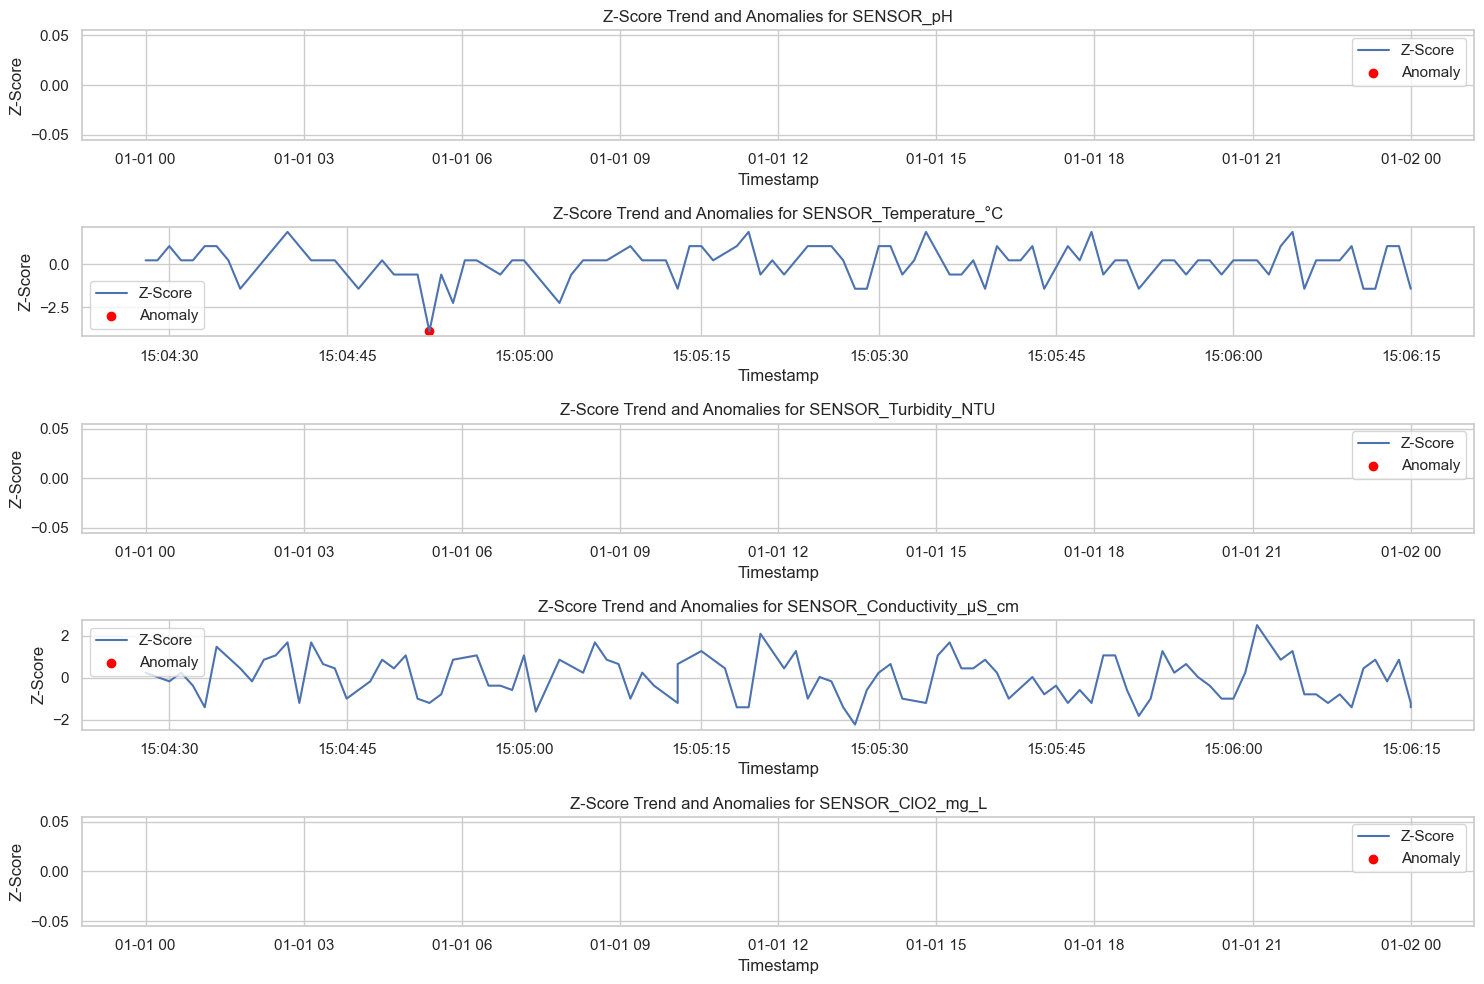

In [9]:
# Calculate mean and std per sensor
stats = df.groupby('sensor_id')['numeric_value'].agg(['mean', 'std']).rename(columns={'mean':'mean_val', 'std':'std_val'})

# Merge stats back to df
df = df.join(stats, on='sensor_id')

# Calculate z-score for each reading
df['z_score'] = (df['numeric_value'] - df['mean_val']) / df['std_val']

# Flag anomalies where absolute z_score > 3
df['anomaly'] = np.abs(df['z_score']) > 3

# Visualize z-scores with anomalies highlighted per sensor
plt.figure(figsize=(15, 10))
for i, sensor in enumerate(df['sensor_id'].unique(), 1):
    plt.subplot(len(df['sensor_id'].unique()), 1, i)
    sensor_data = df[df['sensor_id'] == sensor].sort_index()
    plt.plot(sensor_data.index, sensor_data['z_score'], label='Z-Score')
    anomalies = sensor_data[sensor_data['anomaly']]
    plt.scatter(anomalies.index, anomalies['z_score'], color='red', label='Anomaly')
    plt.title(f'Z-Score Trend and Anomalies for {sensor}')
    plt.xlabel('Timestamp')
    plt.ylabel('Z-Score')
    plt.legend()
    plt.tight_layout()
plt.show()

In [11]:
# Lowercase sensor names before pivoting (for consistency)
df["data_type"] = df["data_type"].str.lower()

# Pivot the data so each data_type becomes a column; alternative pivoting
df_pivot = df.pivot_table(
    index="timestamp",
    columns="data_type",
    values="numeric_value"
).reset_index()


In [12]:
# Drop timestamp temporarily for zscore calc
sensor_data = df_pivot.drop(columns=["timestamp"])
z_scores = sensor_data.apply(zscore, nan_policy='omit')  # handles NaNs

# Flag anomalies: absolute z-score > 3
anomalies = (z_scores.abs() > 3)

# Print how many anomalies per sensor
print("Anomalies detected per sensor:")
print(anomalies.sum())

Anomalies detected per sensor:
data_type
clo2 ms1 (mg/l)         0
conductivity (µs/cm)    0
ph                      0
temperature (°c)        1
turbidity (ntu)         0
dtype: int64


## Identify Sensors Reporting Constant Zero Values (Calibration Issues) and Stuck Sensors

In [13]:
# Sensors with readings constantly near zero (using tolerance of 0.001)
zero_sensors = df.groupby('sensor_id')['numeric_value'].apply(lambda x: np.all(np.abs(x) < 0.001))
const_zero_sensors = zero_sensors[zero_sensors].index.tolist()

print("Sensors consistently reporting zero readings (potential calibration issues):")
for sensor in const_zero_sensors:
    print(f"- {sensor}")

# Sensors with constant readings (zero variance)
const_sensors = df.groupby('sensor_id')['numeric_value'].apply(lambda x: x.nunique() == 1)
stuck_sensors = const_sensors[const_sensors].index.tolist()

print("\nSensors reporting constant readings over time (stuck sensors):")
for sensor in stuck_sensors:
    if sensor not in const_zero_sensors:
        print(f"- {sensor}")

Sensors consistently reporting zero readings (potential calibration issues):
- SENSOR_ClO2_mg_L
- SENSOR_Turbidity_NTU

Sensors reporting constant readings over time (stuck sensors):
- SENSOR_pH


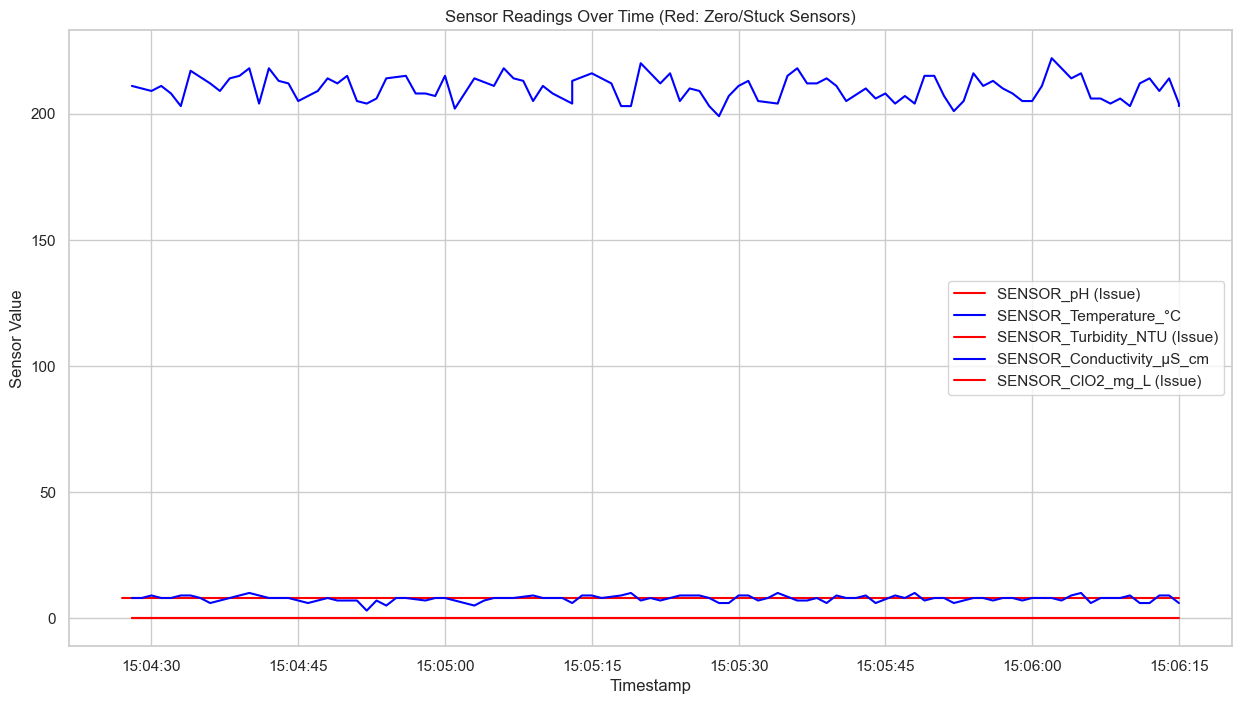

In [14]:
# Visualize constant zero and stuck sensors' readings over time (highlighting in red)
plt.figure(figsize=(15, 8))
for sensor in df['sensor_id'].unique():
    sensor_data = df[df['sensor_id'] == sensor].sort_index()
    color = 'red' if sensor in const_zero_sensors or sensor in stuck_sensors else 'blue'
    plt.plot(sensor_data.index, sensor_data['numeric_value'], color=color, label=f'{sensor} {"(Issue)" if color=="red" else ""}')
plt.title('Sensor Readings Over Time (Red: Zero/Stuck Sensors)')
plt.xlabel('Timestamp')
plt.ylabel('Sensor Value')
plt.legend()
plt.show()


## Temperature Variability Analysis

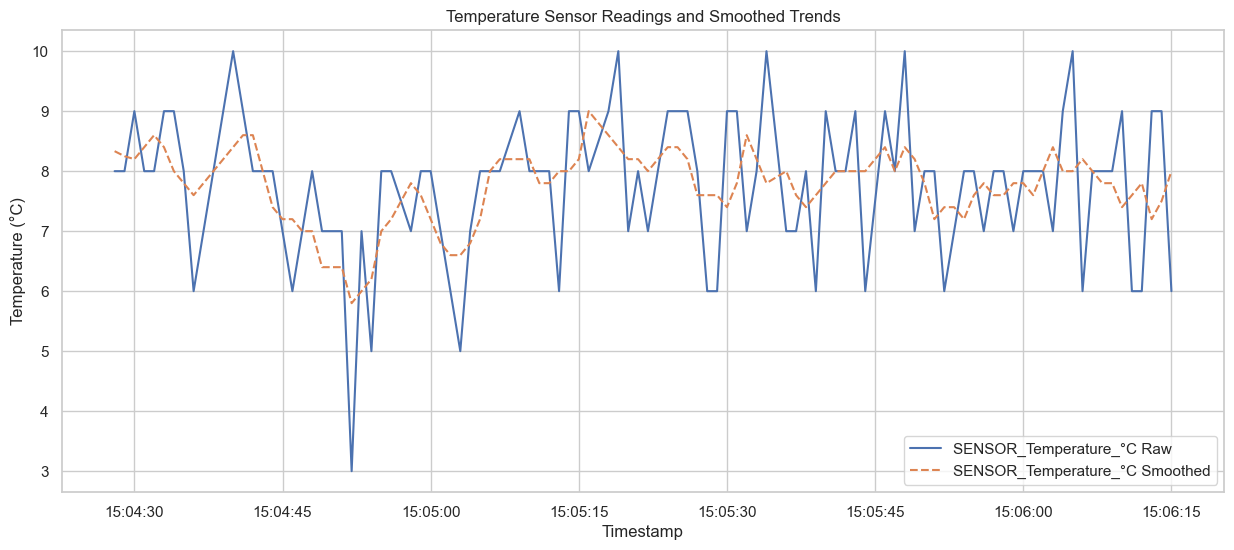

In [15]:
# Filter temperature sensor data
temp_sensor_id = [s for s in df['sensor_id'].unique() if 'Temperature' in s]
temp_data = df[df['sensor_id'].isin(temp_sensor_id)].sort_index()

# Plot raw and smoothed temperature data
plt.figure(figsize=(15, 6))
for sensor in temp_sensor_id:
    sensor_data = temp_data[temp_data['sensor_id'] == sensor]
    plt.plot(sensor_data.index, sensor_data['numeric_value'], label=f'{sensor} Raw')
    smooth_temp = sensor_data['numeric_value'].rolling(window=5, min_periods=1, center=True).mean()
    plt.plot(sensor_data.index, smooth_temp, label=f'{sensor} Smoothed', linestyle='--')
plt.title('Temperature Sensor Readings and Smoothed Trends')
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

### Additional Analysis and Visualization

#### Distribution Analysis per Sensor (To see common range and outliers)

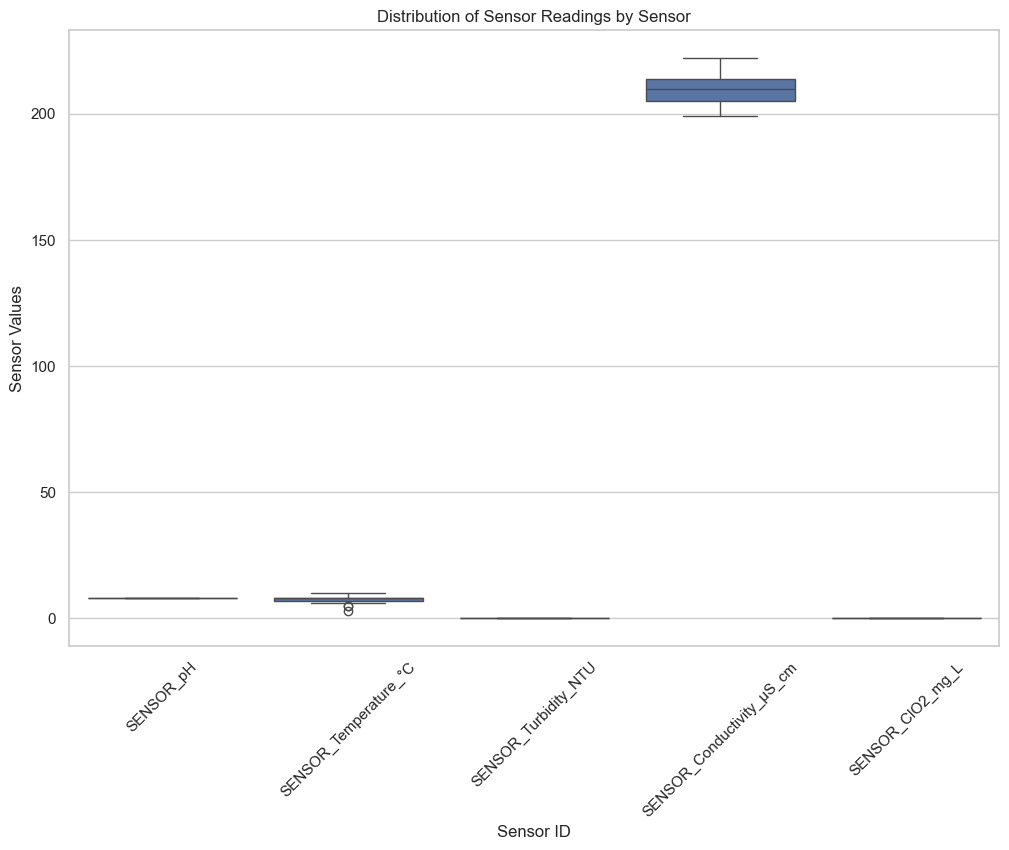

In [16]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='sensor_id', y='numeric_value')
plt.title('Distribution of Sensor Readings by Sensor')
plt.xlabel('Sensor ID')
plt.ylabel('Sensor Values')
plt.xticks(rotation=45)
plt.show()

#### Correlation Between Different Sensors (at the same timestamps)

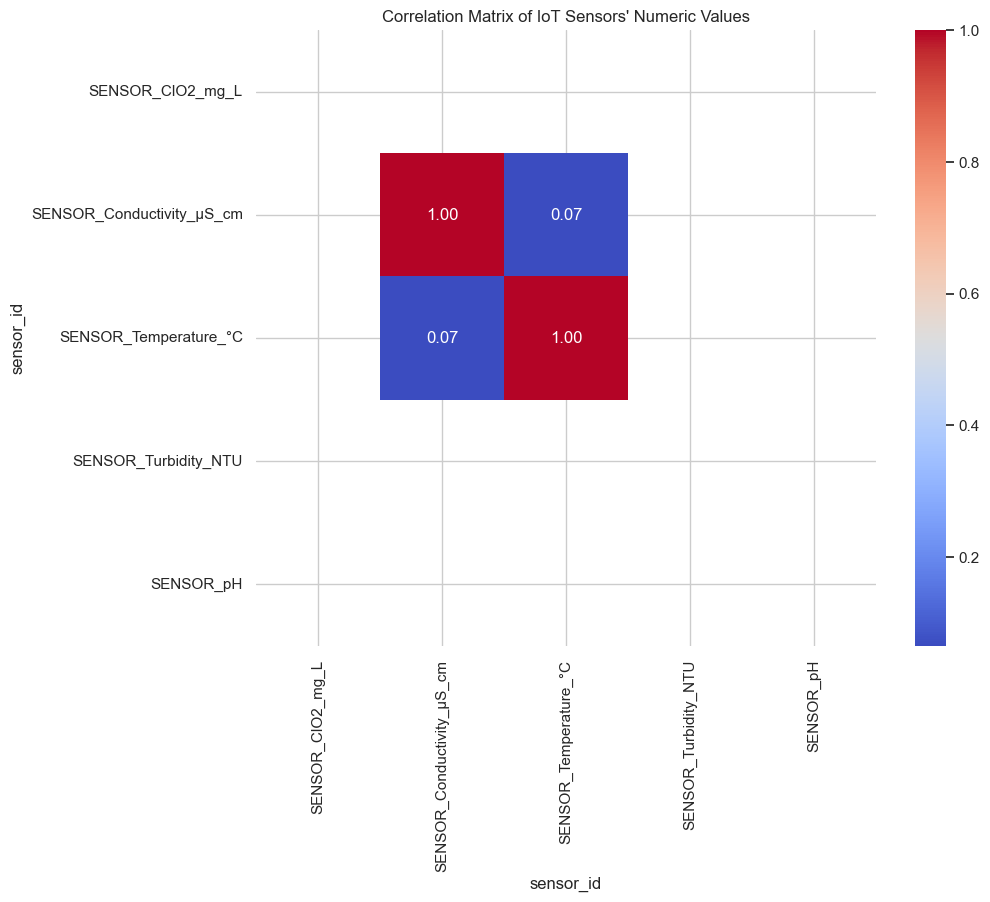

In [21]:
# Pivot data for correlation: index = timestamp, columns = sensor_id, values = numeric_value
pivot_df = df.pivot_table(index=df.index, columns='sensor_id', values='numeric_value')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of IoT Sensors' Numeric Values")
plt.show()

#### Alert on Sudden Large Changes per Sensor (using difference threshold)

In [22]:
df['diff'] = df.groupby('sensor_id')['numeric_value'].diff().abs()
threshold = 3 * df['diff'].std()  # Using 3 standard deviations as threshold

large_changes = df[df['diff'] > threshold]

print("\nLarge sudden changes in sensor readings (possible anomalies):")
for idx, row in large_changes.iterrows():
    print(f"Timestamp: {idx}, Sensor: {row['sensor_id']}, Change: {row['diff']:.2f}")


Large sudden changes in sensor readings (possible anomalies):
Timestamp: 2025-06-11 15:04:34, Sensor: SENSOR_Conductivity_µS_cm, Change: 14.00
Timestamp: 2025-06-11 15:04:41, Sensor: SENSOR_Conductivity_µS_cm, Change: 14.00
Timestamp: 2025-06-11 15:04:42, Sensor: SENSOR_Conductivity_µS_cm, Change: 14.00
Timestamp: 2025-06-11 15:04:51, Sensor: SENSOR_Conductivity_µS_cm, Change: 10.00
Timestamp: 2025-06-11 15:04:54, Sensor: SENSOR_Conductivity_µS_cm, Change: 8.00
Timestamp: 2025-06-11 15:05:00, Sensor: SENSOR_Conductivity_µS_cm, Change: 8.00
Timestamp: 2025-06-11 15:05:01, Sensor: SENSOR_Conductivity_µS_cm, Change: 13.00
Timestamp: 2025-06-11 15:05:09, Sensor: SENSOR_Conductivity_µS_cm, Change: 8.00
Timestamp: 2025-06-11 15:05:13, Sensor: SENSOR_Conductivity_µS_cm, Change: 9.00
Timestamp: 2025-06-11 15:05:18, Sensor: SENSOR_Conductivity_µS_cm, Change: 9.00
Timestamp: 2025-06-11 15:05:20, Sensor: SENSOR_Conductivity_µS_cm, Change: 17.00
Timestamp: 2025-06-11 15:05:22, Sensor: SENSOR_Cond

## Insights and Findings

**Basic and Smoothed Trend Observations (Line Plot)**  

The raw line plots of sensor readings over time reveal natural fluctuations in parameters such as temperature and conductivity. Smoothed plots using a rolling average window of 5 readings successfully reduce short-term noise, allowing clearer identification of underlying trends.

**Descriptive Statistics**


| **Sensor**                      | **Summary of Stats**                                 | **Insights**                                          | **Recommendations**                                         |
| ------------------------------- | ---------------------------------------------------- | ----------------------------------------------------- | ----------------------------------------------------------- |
| **SENSOR\_ClO₂\_mg\_L**         | Count: 52, Mean: 0.0, Std: 0.0, All zeros            | Values are consistently zero                          | Check sensor functionality or if chlorine dioxide is absent |
| **SENSOR\_Conductivity\_µS/cm** | Count: 100, Mean: \~210, Std: \~4.85, Range: 199-222 | Stable conductivity with low variation                | Sensor working normally; continue monitoring                |
| **SENSOR\_Temperature\_°C**     | Count: 100, Mean: \~7.74, Std: \~1.22, Range: 3-10   | Moderate temperature variation, within expected range | Monitor for environmental or seasonal changes               |
| **SENSOR\_Turbidity\_NTU**      | Count: 100, Mean: 0.0, Std: 0.0, All zeros           | No turbidity detected or sensor issue                 | Verify sensor functionality or environmental conditions     |
| **SENSOR\_pH**                  | Count: 100, Mean: 8.0, Std: 0.0, Constant 8          | pH readings are constant without variation            | Check calibration or sensor errors                          |

**Anomaly Detection via Z-Score**  

Computing z-scores for each sensor relative to its mean and standard deviation enabled detection of extreme outliers (|z| > 3). Visualizations highlight these anomalies distinctly over time across sensors, providing a reliable method for flagging unusual values for further investigation or sensor calibration updates.

**Identification of Calibration Issues and Stuck Sensors**  

Several sensors consistently report zero values, suggesting potential calibration issues or sensor malfunctions. Additionally, sensors exhibiting constant unvarying readings over time (zero variance) are identified as stuck sensors. These conditions impair data quality and require maintenance or replacement to ensure reliable monitoring.

**Temperature Variability**  

Temperature sensors demonstrate measurable variability with standard deviations indicating environmental changes rather than sensor error. Smoothed trends confirm natural fluctuation patterns and reinforce sensor reliability for temperature measurements. This variability can be critical to understand water quality dynamics influenced by temperature.

**Additional Analysis and Visualizations**  
- Boxplots reveal distribution ranges per sensor, indicating any skewness or frequent outliers, critical for quality control.  
- Correlation heatmap shows how sensor parameters relate to each other, useful for multivariate anomaly detection and understanding sensor interdependencies.  
- Detection of large rapid changes in sensor values highlights potential events or measurement errors requiring verification.
